In [2]:
%pip install opencv-python

In [3]:
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [4]:
def init_params(nx, nh, ny):
    W1 = np.random.normal(0, 0.3, (nh, nx + 1))
    W2 = np.random.normal(0, 0.3, (ny, nh + 1))
    params = {'W1': W1, 'W2': W2}
    return params

def tanh(x):
    result = np.tanh(x)
    return result

def softmax(x):
    result = np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)
    return result

def forward(params, X):
    W1 = params['W1']
    W2 = params['W2']     

    # add bias column because the matrix will be transposed
    ones_vector = np.ones(X.shape[0])
    A0 = np.insert(X, 0, ones_vector, axis=1)
    Z1 = np.matmul(W1, A0.transpose())
    A1 = tanh(Z1)

    # add bias row because the matrix won't be transposed
    ones_vector = np.ones(A1.shape[1])
    A1 = np.insert(A1, 0, ones_vector, axis=0)
    Z2 =np.matmul(W2, A1)
    A2 = softmax(Z2)

    outputs = {'A0': A0, 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return outputs

def loss_accuracy(y_pred, y):
    loss = -np.mean(np.sum(y * np.log(y_pred), axis=1))
    accuracy = np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
    return loss, accuracy

def tanh_derivative(x):
    result = 1 - np.tanh(x) ** 2
    return result

def backward(X, params, outputs, Y):
    X = np.vstack([np.ones(X.shape[0]), X.T])

    d2 = outputs['A2'] - Y.T
    dW2 = np.matmul(d2, outputs['A1'].T)

    d1 = np.matmul(params['W2'].T[1:], d2) * tanh_derivative(outputs['Z1'])
    dW1 = np.matmul(d1, X.T)

    grads = {'dW1': dW1, 'dW2': dW2}
    return grads

def sgd(params, grads, eta):
    params['W1'] -= eta * grads['dW1']
    params['W2'] -= eta * grads['dW2']
    return params

def one_hot_encoding(y, max):
    result = np.eye(max)[y]
    return result

def one_hot_decoding(y):
    result = np.argmax(y, axis=0).reshape((1,-1))
    return result

In [5]:
mnist_train = pd.read_csv('mnist_train.csv')
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(f"The shape of the training set is: {mnist_train.shape[0]} x {mnist_train.shape[1] - 1}")

The shape of the training set is: 60000 x 784


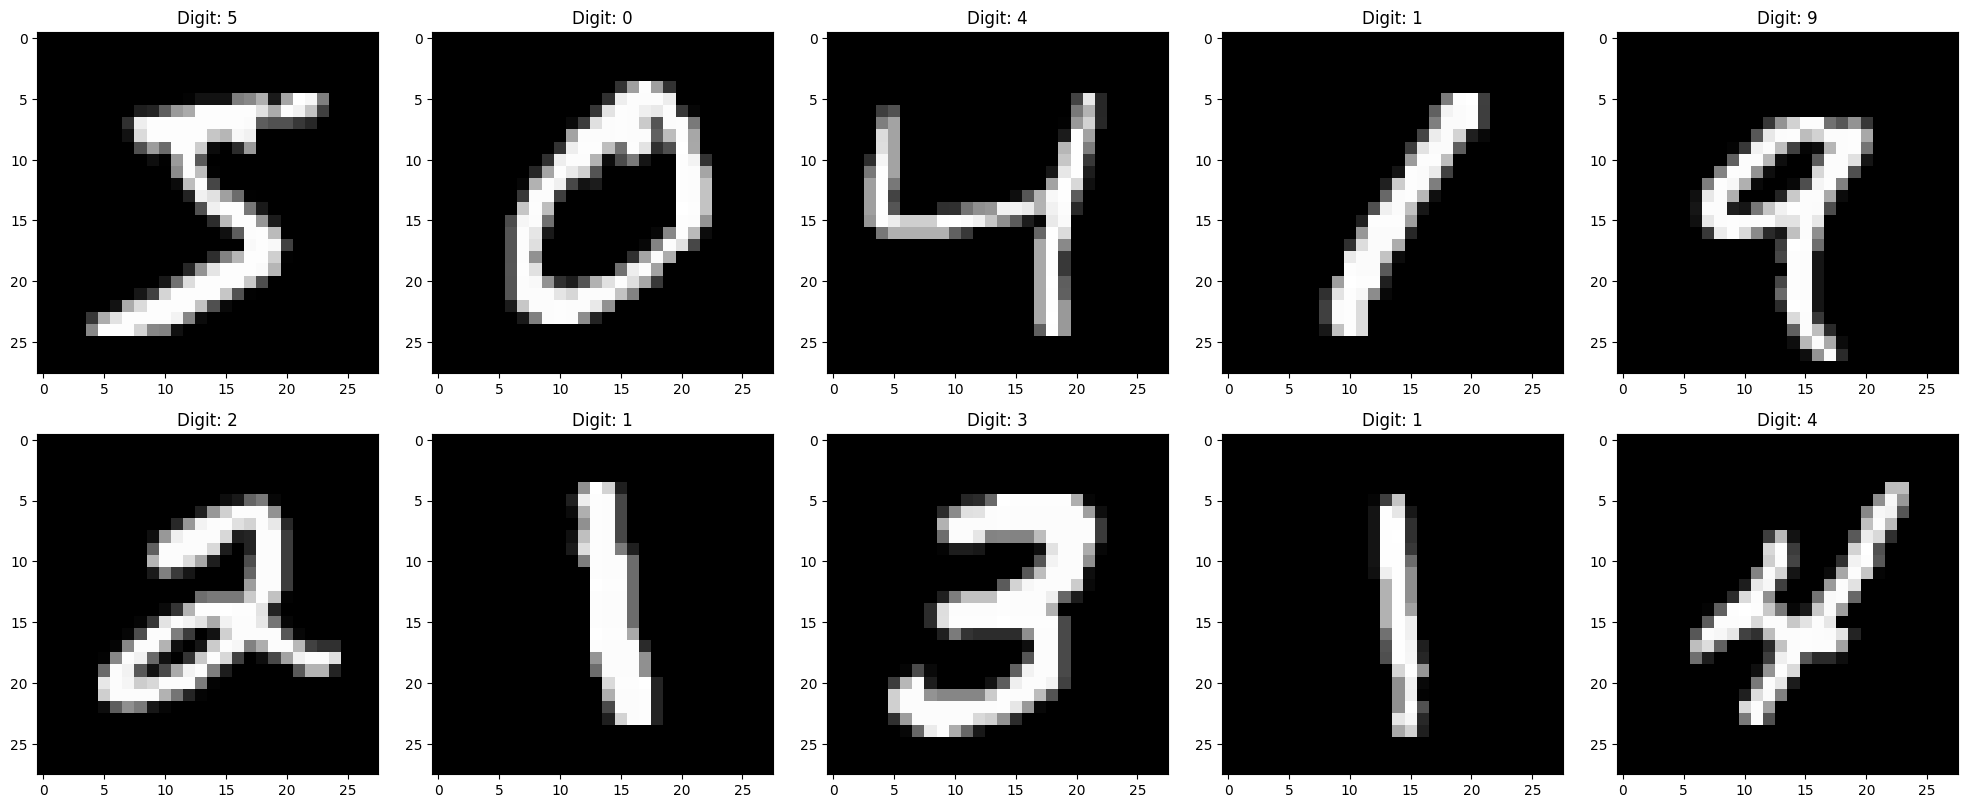

In [7]:
label = np.array(mnist_train.iloc[:,0])
images = mnist_train.iloc[:,1:].values.astype('float32')

fig = plt.figure(figsize=(20,20))
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(np.reshape(images[i], (28,28)), cmap='gray')
    plt.tight_layout()
    ax.set_title("Digit: {}".format(label[i]))

In [8]:
X_train = mnist_train.drop(['label'], axis=1)
y_train = np.array(mnist_train['label'])

In [9]:
# Normalizing the RGB codes by dividing it to the max RGB value(255)
X_train = X_train / 255

In [10]:
max = np.unique(y_train).size
y_train = one_hot_encoding(y_train, max)

In [11]:
def train(X, y, hidden, batch_size, num_epochs, num_batches, learning_rate, history=False):

    # Initialize the network parameters
    params = init_params(X.shape[1], hidden, y.shape[1])

    loss_hist = np.array([])
    accuracy_hist = np.array([])

    for i in range(num_epochs):

        # shuffle the data
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X.iloc[indices]
        y = y[indices]

        start_timer = time.time()
    
        for j in range(num_batches):

            # Load a batch of data
            start = j * batch_size
            end = start + batch_size
            x_batch = X[start:end]
            y_batch = y[start:end]
            # Forward pass
            outputs = forward(params, x_batch)
            # Compute loss and accuracy
            loss, accuracy = loss_accuracy(outputs['A2'].T, y_batch)
            if j % 50 == 0:
                loss_hist = np.append(loss_hist, loss)
                accuracy_hist = np.append(accuracy_hist, accuracy)
            # Backward pass
            grads = backward(x_batch, params, outputs, y_batch)
            # Update the parameters
            params = sgd(params, grads, learning_rate)
        
        end_timer = time.time()
        
        if history:
            print(f"• Epoch {str(i+1).zfill(2)}: loss = {loss:.3f} | accuracy = {accuracy:.3f} | time = {end_timer - start_timer:.3f} seconds")
    
    print("✅ Training complete!")

    return params, loss_hist, accuracy_hist

In [12]:
def plot_loss_accuracy(loss, accuracy, title='Loss & Accuracy history curves'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    ax[0].plot(loss, label='Training Loss', color='blue')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(accuracy, label='Training Accuracy', color='green')
    ax[1].set_title('Training Accuracy')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

In [13]:
learning_rate = 0.01
batch_size = 128
epochs = 50
batches = X_train.shape[0] // batch_size

In [14]:
Weights_32, train_loss, train_accuracy = train(X_train, y_train, 32, batch_size, epochs, batches, learning_rate, history=True)

• Epoch 01: loss = 0.229 | accuracy = 0.922 | time = 1.369 seconds
• Epoch 02: loss = 0.132 | accuracy = 0.961 | time = 0.928 seconds
• Epoch 03: loss = 0.088 | accuracy = 0.977 | time = 0.852 seconds
• Epoch 04: loss = 0.088 | accuracy = 0.969 | time = 0.900 seconds
• Epoch 05: loss = 0.118 | accuracy = 0.961 | time = 1.022 seconds
• Epoch 06: loss = 0.072 | accuracy = 0.969 | time = 0.950 seconds
• Epoch 07: loss = 0.047 | accuracy = 0.984 | time = 0.909 seconds
• Epoch 08: loss = 0.111 | accuracy = 0.961 | time = 0.762 seconds
• Epoch 09: loss = 0.095 | accuracy = 0.969 | time = 0.978 seconds
• Epoch 10: loss = 0.101 | accuracy = 0.977 | time = 0.802 seconds
• Epoch 11: loss = 0.071 | accuracy = 0.977 | time = 1.470 seconds
• Epoch 12: loss = 0.038 | accuracy = 0.992 | time = 1.088 seconds
• Epoch 13: loss = 0.128 | accuracy = 0.961 | time = 0.909 seconds
• Epoch 14: loss = 0.089 | accuracy = 0.969 | time = 1.036 seconds
• Epoch 15: loss = 0.057 | accuracy = 0.984 | time = 0.861 sec

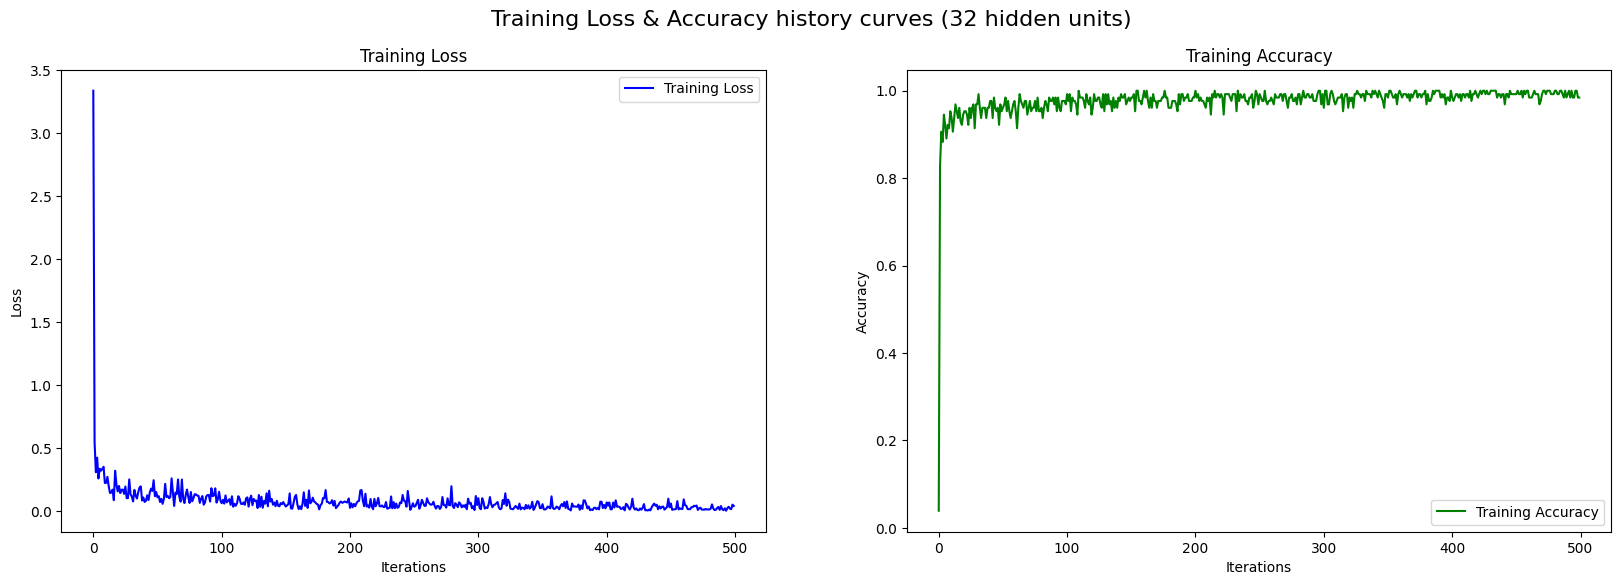

In [15]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (32 hidden units)')

In [16]:
Weights_64, train_loss, train_accuracy = train(X_train, y_train, 64, batch_size, epochs, batches, learning_rate, history=False)

✅ Training complete!


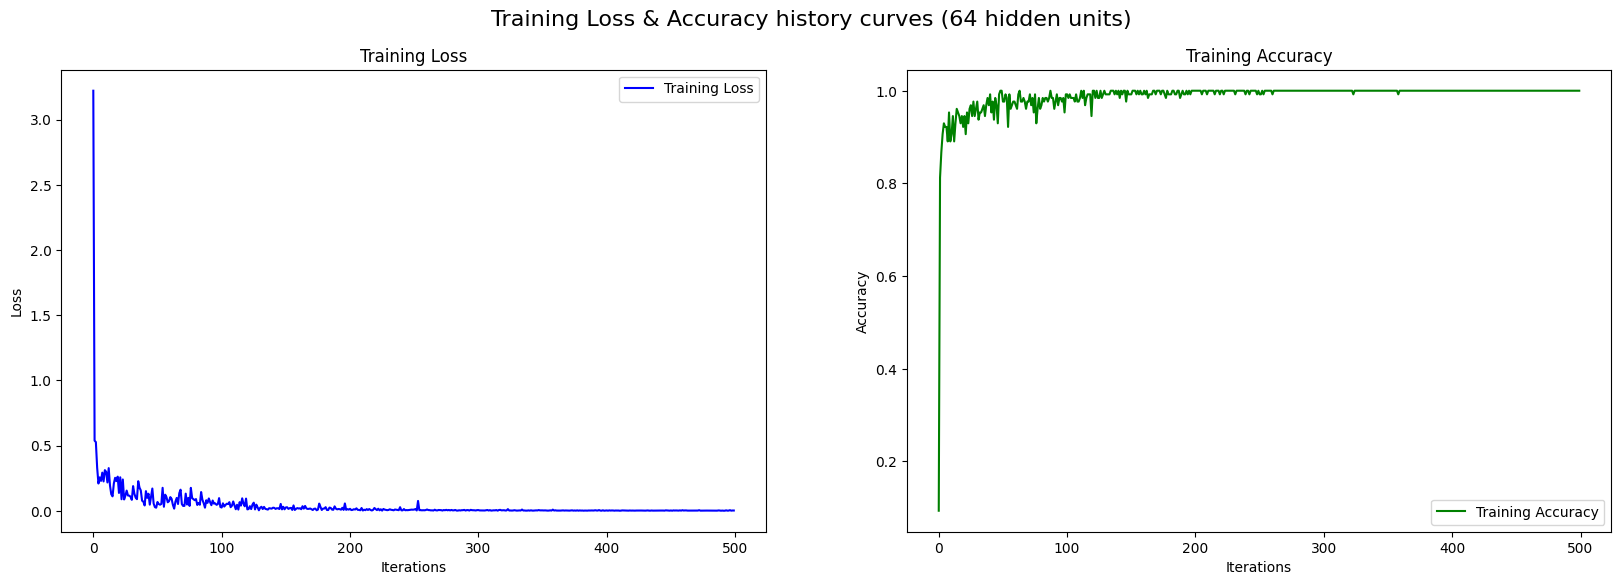

In [17]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (64 hidden units)')

In [29]:
Weights_128, train_loss, train_accuracy = train(X_train, y_train, 256, batch_size, epochs, batches, learning_rate, history=False)

✅ Training complete!


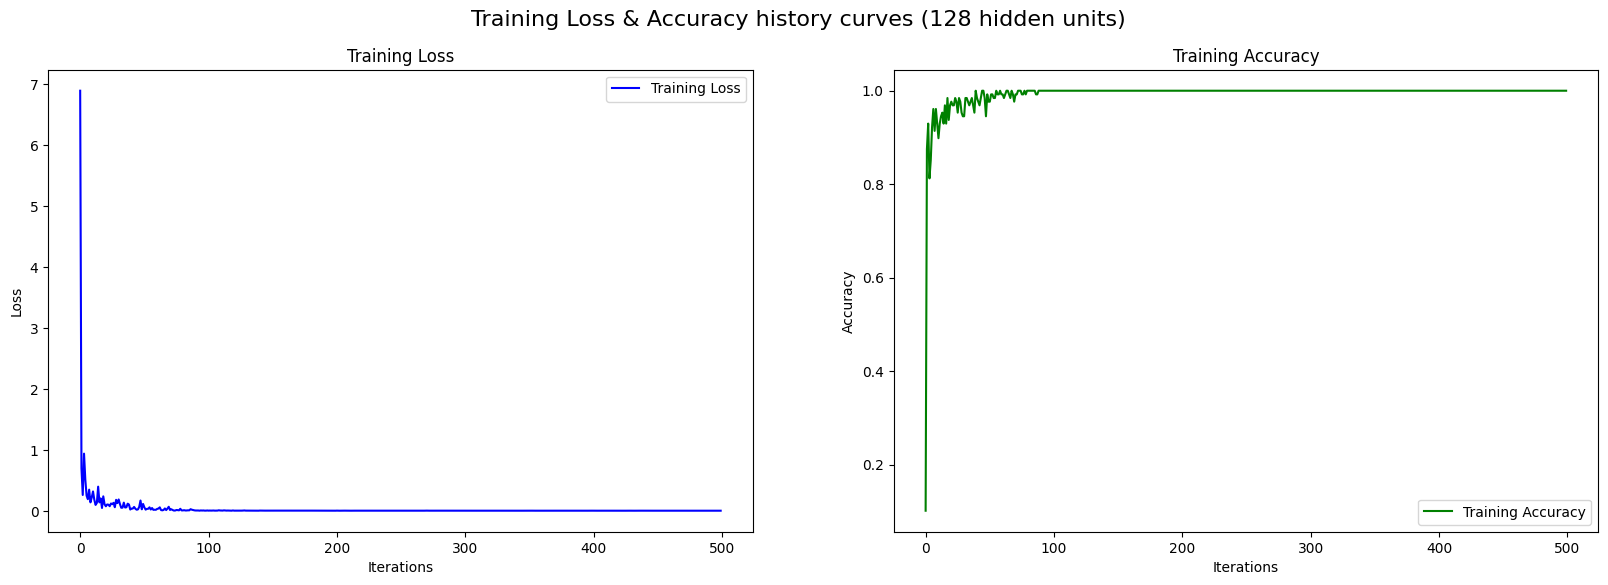

In [30]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (128 hidden units)')

In [31]:
mnist_test = pd.read_csv('mnist_test.csv')
X_test = mnist_test.drop(['label'], axis=1)
y_test = mnist_test['label']

In [32]:
print(f"The shape of the testing set is: {mnist_test.shape[0]} x {mnist_test.shape[1] - 1}")

The shape of the testing set is: 10000 x 784


In [33]:
X_test = X_test / 255
y_test = np.reshape(y_test, (1,-1))

In [34]:
outputs = forward(Weights_32, X_test)
y_pred_32 = one_hot_decoding(outputs['A2'])

outputs = forward(Weights_64, X_test)
y_pred_64 = one_hot_decoding(outputs['A2'])

outputs = forward(Weights_128, X_test)
y_pred_128 = one_hot_decoding(outputs['A2'])

In [37]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])

for i in range(3):
    report_df = pd.DataFrame(classification_report(y_test[0], [y_pred_32[0], y_pred_64[0], y_pred_128[0]][i], output_dict=True)).T
    accuracy = report_df.loc['accuracy', 'precision']
    recall = report_df.loc['macro avg', 'recall']
    precision = report_df.loc['macro avg', 'precision']
    f1_score = report_df.loc['macro avg', 'f1-score']

    metrics_df.loc[i] = ['MLP-' + str([32, 64, 256][i]), accuracy, recall, precision, f1_score]

metrics_df

,Model,Accuracy,Recall,Precision,F1-Score
0,MLP-32,0.9552,0.954487,0.954912,0.954629
1,MLP-64,0.9673,0.966802,0.966966,0.966861
2,MLP-256,0.9742,0.973902,0.974075,0.973966


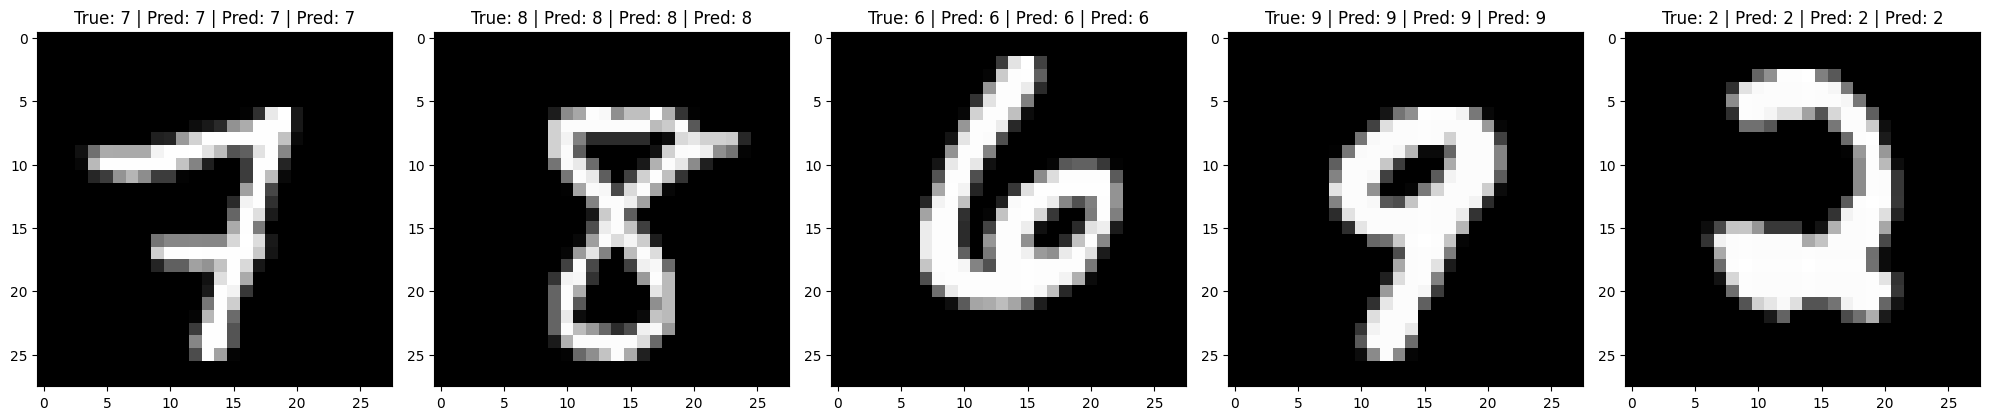

In [36]:
indices = np.random.choice(X_test.shape[0], 5)
images = X_test.iloc[indices].values.astype('float32')
labels = y_test[0][indices]

y_hat_32 = forward(Weights_32, images)['A2']
y_hat_32 = one_hot_decoding(y_hat_32)
y_hat_64 = forward(Weights_64, images)['A2']
y_hat_64 = one_hot_decoding(y_hat_64)
y_hat_128 = forward(Weights_128, images)['A2']
y_hat_128 = one_hot_decoding(y_hat_128)

fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(np.reshape(images[i], (28,28)), cmap='gray')
    plt.tight_layout()
    ax.set_title(f"True: {labels[i]} | Pred: {y_hat_32[0][i]} | Pred: {y_hat_64[0][i]} | Pred: {y_hat_128[0][i]}")

plt.show()

In [26]:
image_2 = cv2.imread('test_two.jpg', cv2.IMREAD_GRAYSCALE)
image_5 = cv2.imread('test_five.jpg', cv2.IMREAD_GRAYSCALE)
image_7 = cv2.imread('test_seven.jpg', cv2.IMREAD_GRAYSCALE)
image_8 = cv2.imread('test_eight.jpg', cv2.IMREAD_GRAYSCALE)

In [27]:
imgs = [image_2, image_5, image_7, image_8]
labels = [2, 5, 7, 8]

TypeError: Image data of dtype object cannot be converted to float

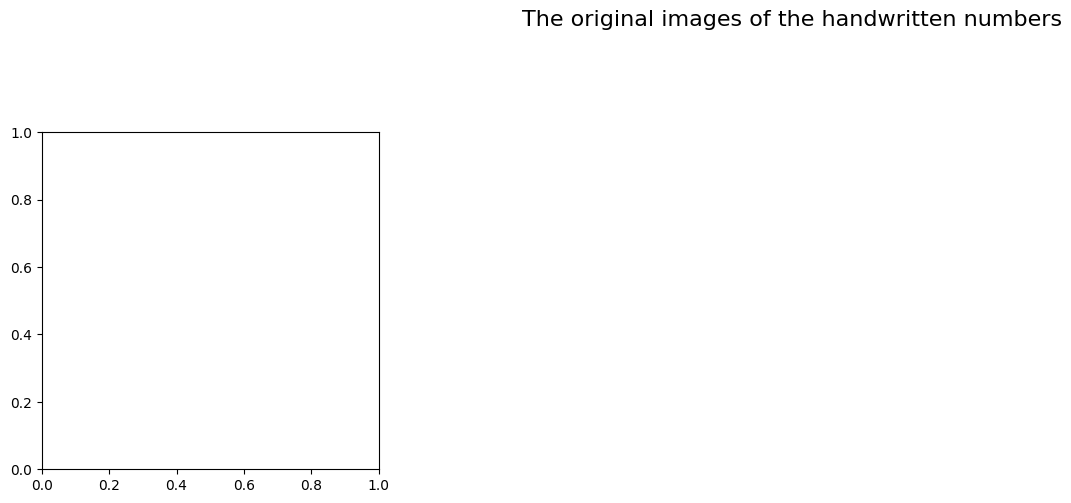

In [28]:
fig= plt.figure(figsize=(20,6))
fig.suptitle('The original images of the handwritten numbers', fontsize=16)
for i in range(len(imgs)):
    ax = fig.add_subplot(1, 4, i+1)
    ax.imshow(imgs[i], cmap='gray')
    ax.set_title(f"True label: {labels[i]}")

plt.tight_layout()
plt.show()

In [ ]:
for i in range(len(imgs)):
    _, imgs[i] = cv2.threshold(imgs[i], 127, 255, cv2.THRESH_BINARY_INV)

In [ ]:
r_imgs = [cv2.resize(image, (28, 28)) for image in imgs]

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
fig = plt.figure(figsize=(20,6))
fig.suptitle('The resized images of the handwritten numbers', fontsize=16)
for i in range(len(r_imgs)):
    ax = fig.add_subplot(1, 4, i+1)
    ax.imshow(r_imgs[i], cmap='gray')
    ax.set_title(f"True label: {labels[i]}")

plt.tight_layout()
plt.show()

NameError: name 'r_imgs' is not defined

<Figure size 2000x600 with 0 Axes>

In [ ]:
f_imgs = [img.flatten() for img in r_imgs]
test_imgs = np.array([img / 255 for img in f_imgs])

NameError: name 'r_imgs' is not defined

In [ ]:
y_hat_32 = forward(Weights_32, test_imgs)['A2']
y_hat_32 = one_hot_decoding(y_hat_32)

y_hat_64 = forward(Weights_64, test_imgs)['A2']
y_hat_64 = one_hot_decoding(y_hat_64)

y_hat_128 = forward(Weights_128, test_imgs)['A2']
y_hat_128 = one_hot_decoding(y_hat_128)

NameError: name 'test_imgs' is not defined

NameError: name 'test_imgs' is not defined

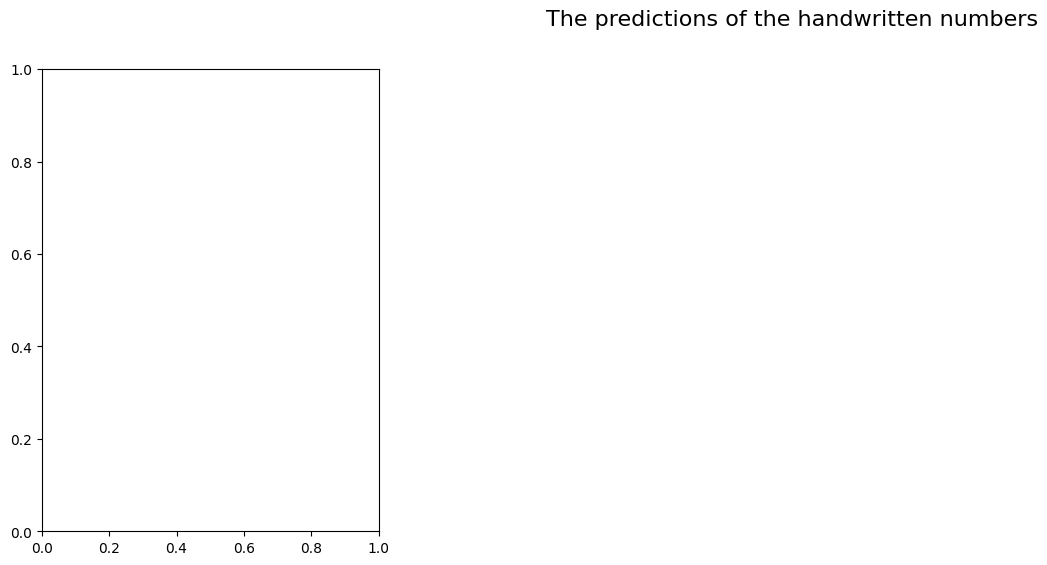

In [ ]:
fig = plt.figure(figsize=(20,6))
fig.suptitle('The predictions of the handwritten numbers', fontsize=16)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    ax.imshow(np.reshape(test_imgs[i], (28,28)), cmap='gray')
    ax.set_title(f"True: {labels[i]} | Pred: {y_hat_32[0][i]} | Pred: {y_hat_64[0][i]} | Pred: {y_hat_128[0][i]}")

plt.tight_layout()
plt.show()